In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx
# import datashader as ds
import plotly.express as px
import sklearn.decomposition as decomp
import sklearn.preprocessing as pre
import matplotlib.colors as colors
import matplotlib.tri as tri
from mpl_toolkits.basemap import Basemap

In [2]:
data = pd.read_csv('master_df_reduced.csv')

In [3]:
data_num = data.select_dtypes(include=[np.number])
data_cat = data.select_dtypes(exclude=[np.number])
cols_num = data_num.columns
cols_cat = data_cat.columns

/Users/tillboehringer/anaconda3/envs/dataproject_UZH/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tillboehringer/anaconda3/envs/dataproject_UZH/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tillboehringer/anaconda3/envs/dataproject_UZH/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tillboehringer/anaconda3/envs/dataproject_UZH/lib/python3.11/site-packages/sea

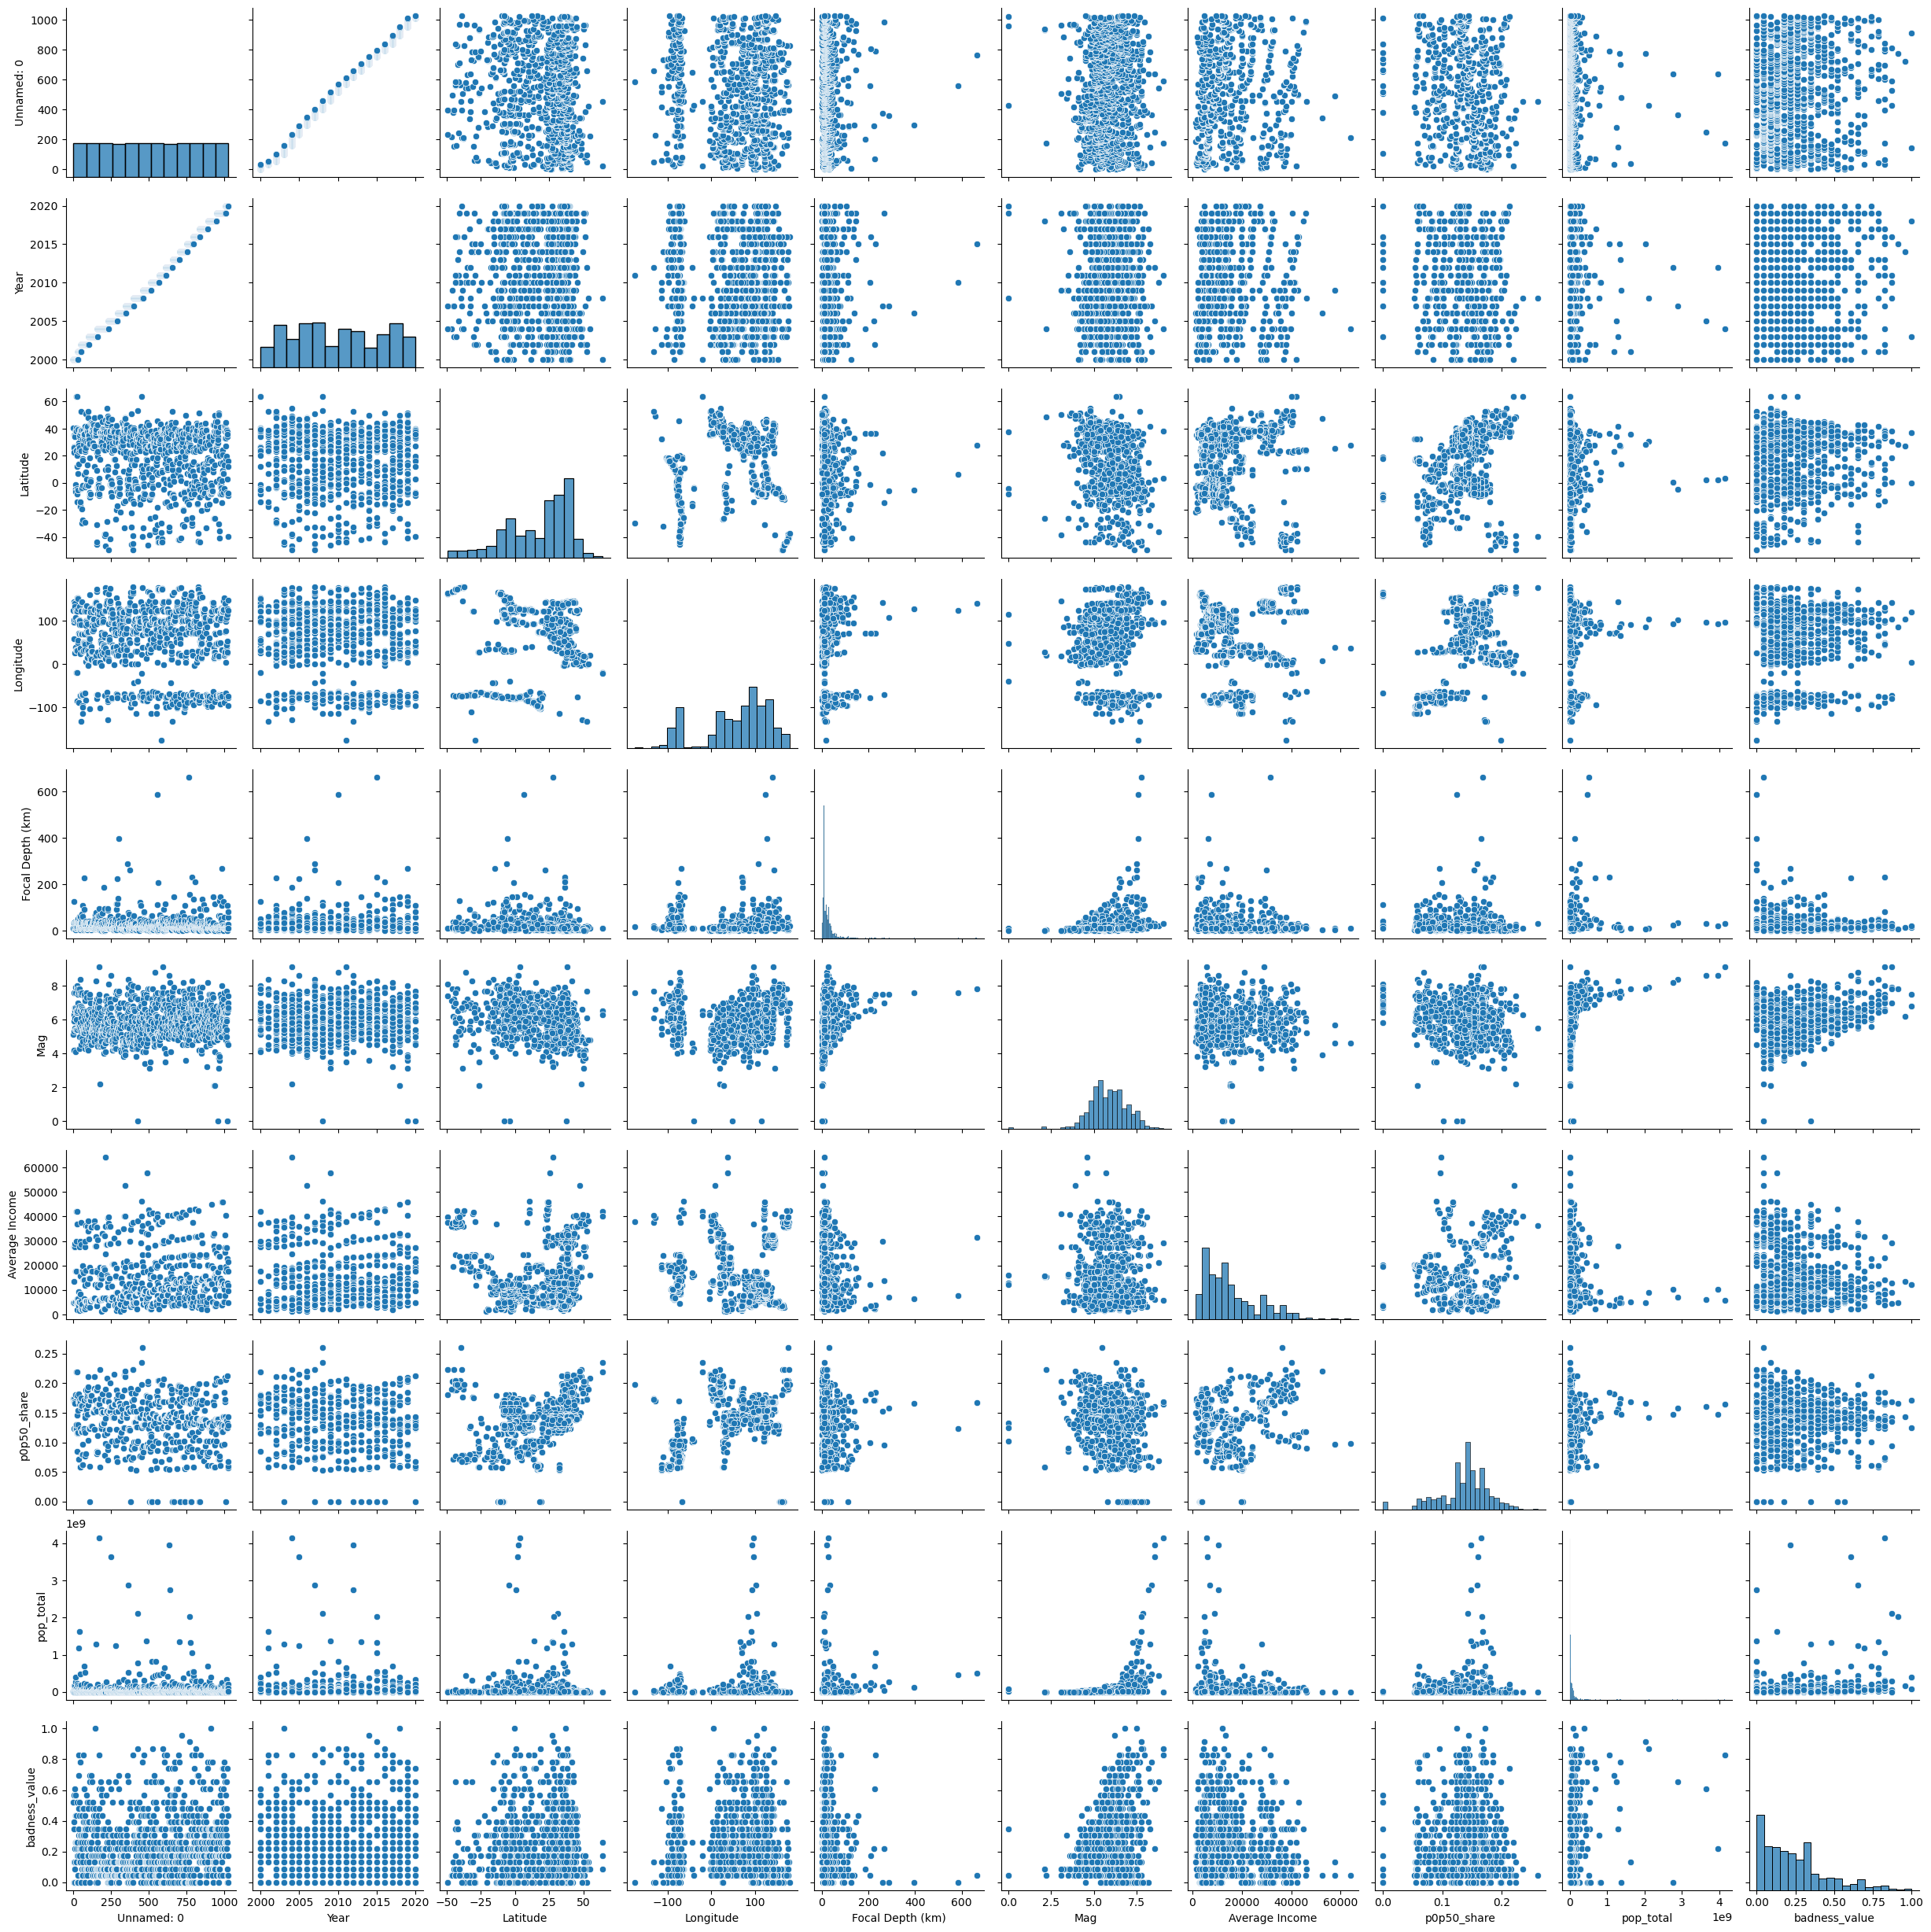

In [4]:
pairplot = sns.pairplot(data=data)

In [5]:
pairplot.figure.savefig('Plots/pairplot.pdf')
# fig.tight_layout()
# fig.savefig(f'Plots/pairplot.pdf', bbox_inches='tight')

In [6]:
data_geo = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude), crs='EPSG:4326')
data_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

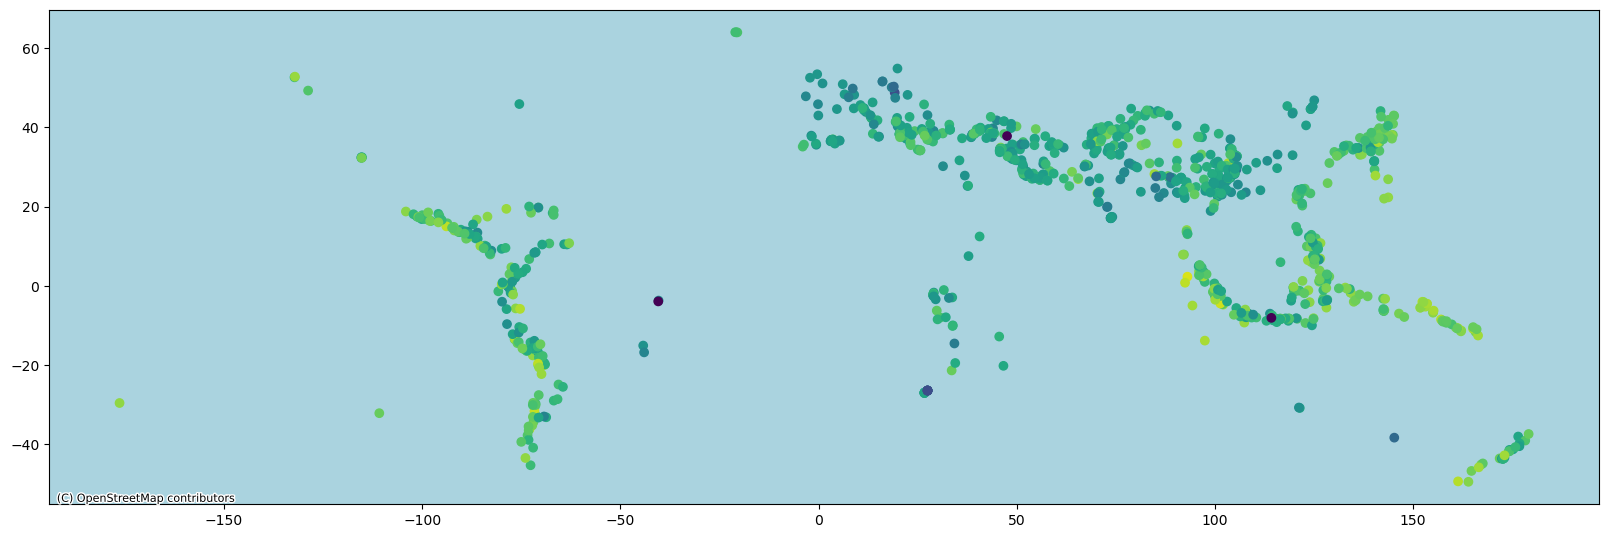

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
ax = data_geo.plot(column='Mag', ax=ax)
cx.add_basemap(ax, source='OpenStreetMap.Mapnik')

<Axes: xlabel='Longitude', ylabel='Latitude'>

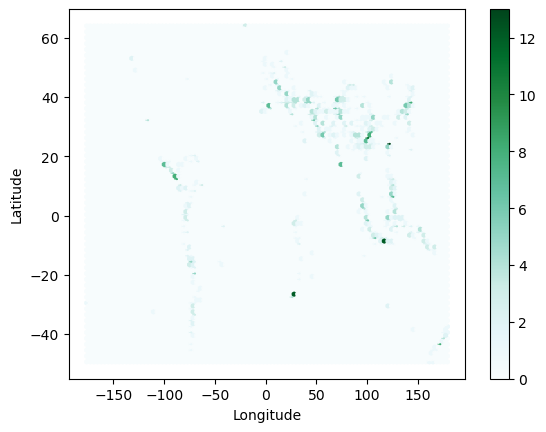

In [8]:
data_geo.plot.hexbin('Longitude', 'Latitude')

In [9]:
fig = px.scatter_geo(data, lat=data.Latitude, lon=data.Longitude, hover_name='Country', color='badness_value', hover_data=['Mag', 'pop_total'])
fig.update_geos(showcountries=True)
fig.show()

In [10]:
# fig.write_html('test.html')

In [11]:
x = data.Longitude
y = data.Latitude
C = data.badness_value

n = 100
xi = np.linspace(x.min(), x.max(), n)
yi = np.linspace(y.min(), y.max(), n)
Xi, Yi = np.meshgrid(xi,yi)

triang = tri.Triangulation(x,y)
interpolator = tri.LinearTriInterpolator(triang, C)

zi = interpolator(Xi, Yi)
zi = np.array(zi)
zi = np.nan_to_num(zi)

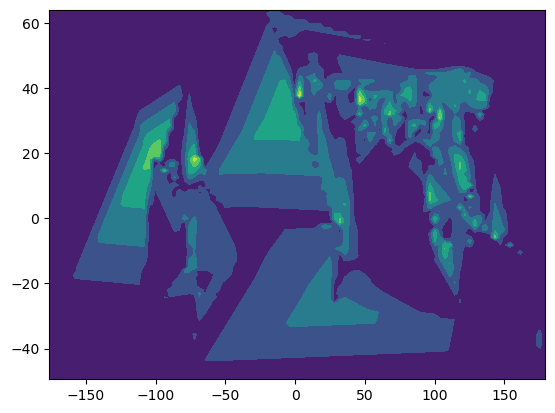

In [12]:
fig, ax = plt.subplots()

ax.contourf(xi, yi, zi)

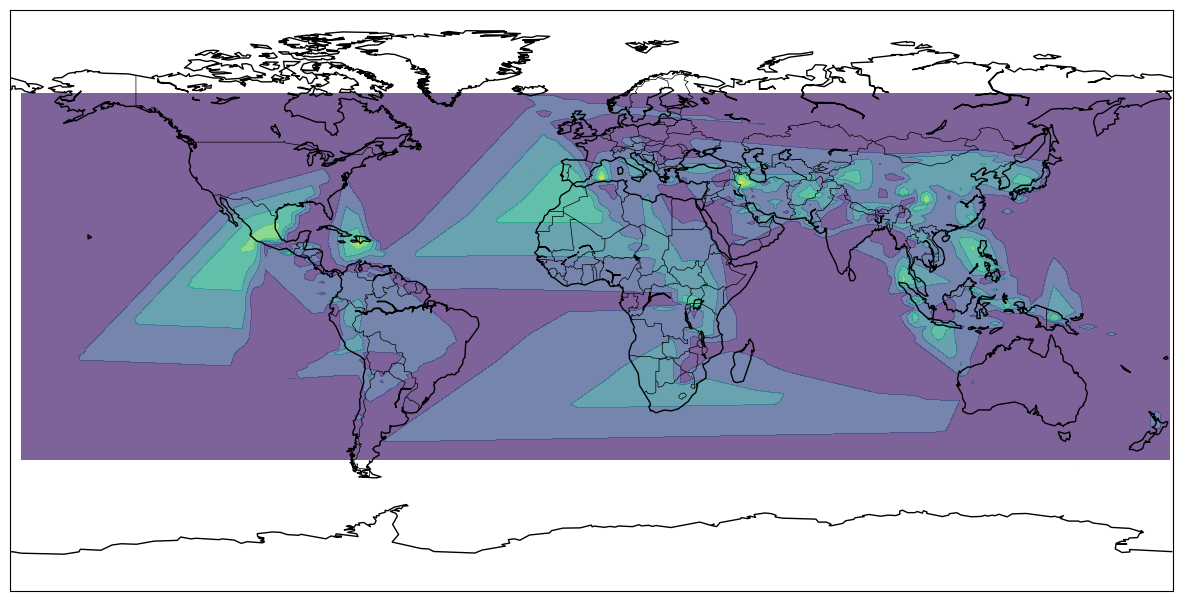

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
m = Basemap(ax=ax)
m.drawcoastlines() # draw coastlines
m.drawcountries() # draw political boundaries
ax.contourf(xi, yi, zi, alpha=0.7)

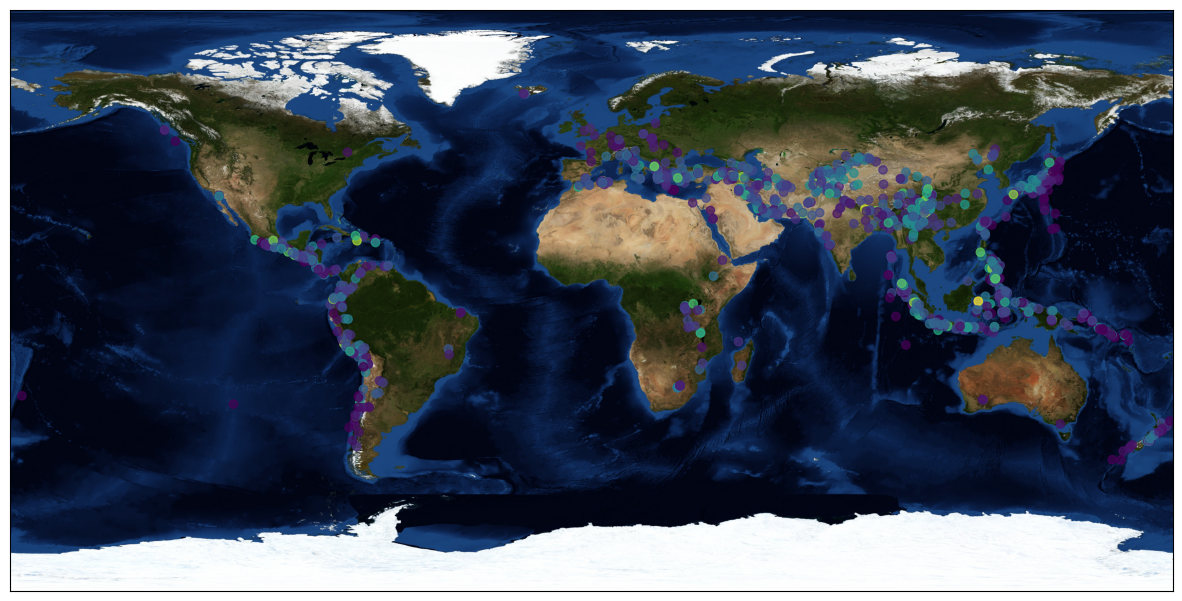

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
m = Basemap(ax=ax)
# m.drawcoastlines() # draw coastlines
# m.drawcountries() # draw political boundaries
m.bluemarble()
ax.scatter(x,y, c=C, alpha=0.7)

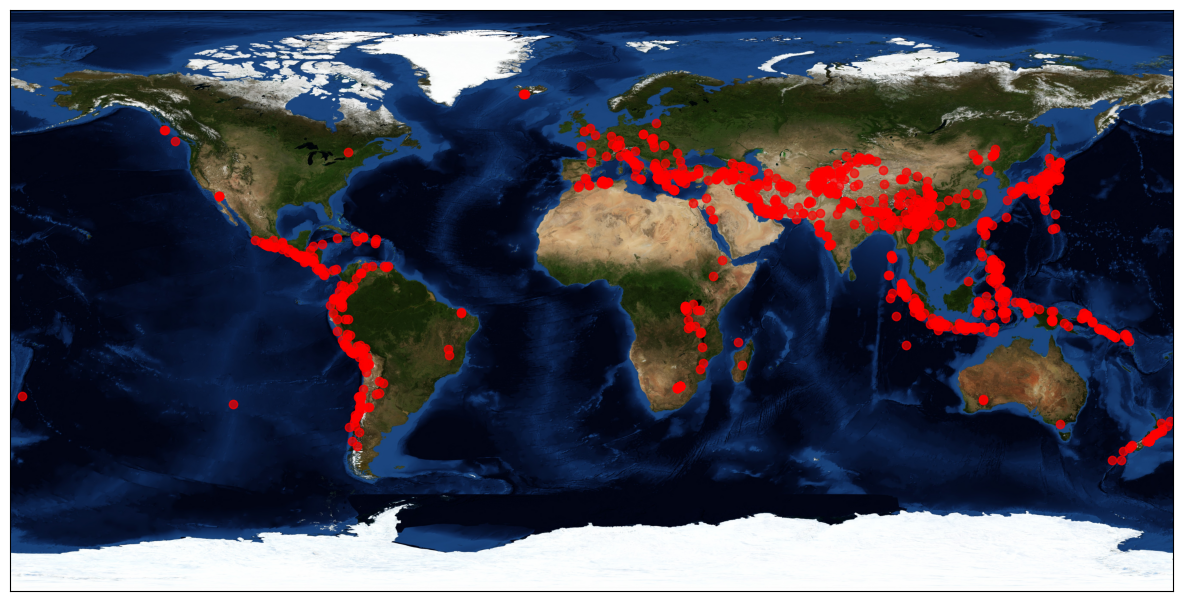

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
m = Basemap(ax=ax)
# m.drawcoastlines() # draw coastlines
# m.drawcountries() # draw political boundaries
m.bluemarble()
ax.scatter(x,y, c='red', alpha=0.7)
fig.savefig('Plots/Map_bluemarbel.pdf', bbox_inches='tight')

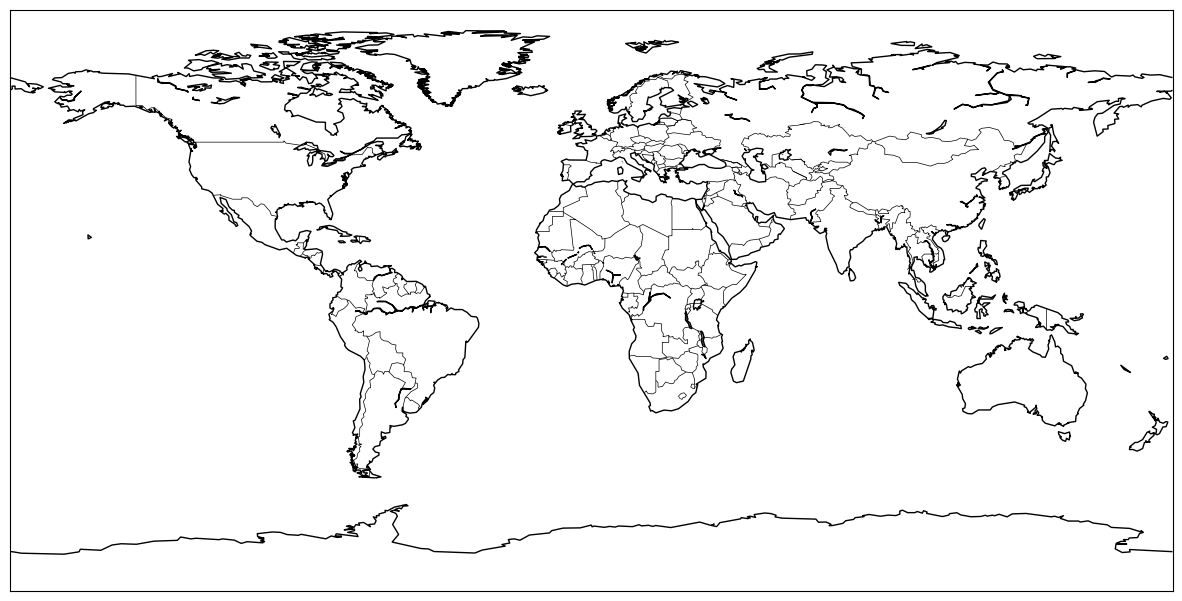

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
m = Basemap(ax=ax)
m.drawcoastlines() # draw coastlines
m.drawcountries() # draw political boundaries
# ax.imshow(xi, yi, zi, alpha=0.7)

In [17]:
import bokeh.plotting as plot
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.io import output_notebook
output_notebook ()
import bokeh.models as bmo

Loading BokehJS ...

In [18]:
geo = data_geo['geometry']
geo = geo.to_crs(epsg=3857)
geo = geo.get_coordinates()

data['x_mer'] = geo.x
data['y_mer'] = geo.y

exp_cmap = bmo.LinearColorMapper(palette="Viridis256", 
                             low = min(data.badness_value), 
                             high = max(data.badness_value))

tooltips = [
    ('ID', '@index'),
    ('Magnitude', '@Mag'),
    ('Badness Value', '@badness_value')
]

In [19]:
p = plot.figure(
    x_range=(-20037508.34, 20037508.34),
    y_range=(-20037508.34, 20037508.34),
    x_axis_type="mercator",
    y_axis_type="mercator",
    tooltips=tooltips,
)

p.add_tile(CARTODBPOSITRON)

data['size'] = data['Mag'] * 1.5

p.scatter(
    x="x_mer",
    y="y_mer",
    size='size',
    color={'field': 'badness_value', 'transform': exp_cmap},
    fill_alpha=0.8,
    source=data,
)

plot.show(p)

In [20]:
from bokeh.plotting import output_file, save
output_file(filename="Plots/Map_interactive.html", title="Map of earthquakes")
save(p)

'/Users/tillboehringer/Library/CloudStorage/Dropbox/Studium/Physik/Semester2/DataScience/Projekt/Earthquake-Project/Plots/Map_interactive.html'